### Distributions of input values

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

import xgcm

import sys
sys.path.append('../modules/')
import helper_func as hf

# Import seaborn
import seaborn as sns

In [2]:
sns.__version__

'0.12.2'

In [3]:
M2LINES_BUCKET ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

In [4]:
# Open all the datasets
Lkey = ['50', '100', '200', '400']

ds = {}
for L in Lkey:
    
    ds_temp = xr.open_zarr(f'{M2LINES_BUCKET}/ML_data/ds_ML_'+L+'km_3D')
    
    ds[L] = ds_temp
ds_tree = DataTree.from_dict(ds)

# Open the mask files
ds_mask_tree = open_datatree(f'{M2LINES_BUCKET}/ML_data/ds_ML_masks', engine='zarr')

In [5]:
output_channels = ['Sfnx','Sfny']                                      

input_channels_all = ['U_x', 'U_y', 
                      'V_x', 'V_y', 
                      'Sx', 'Sy', 'Lfilt']

In [6]:
# Normalize by T_z for some variables
# Center all the data
facs = {}

ds_tree_centered = {}
for L in Lkey:
    
    # Select dataset
    ds = ds_tree[L].ds
    grid = xgcm.Grid(ds, periodic='X')
    
    # Center the variables
    ds_centered = hf.center_data(ds)
    ds_centered['T_z'] = (ds_centered['T_z'].where(ds_centered['T_z']>=5e-5, 5e-5)) #.isel(time=0, XC=0).plot(vmin=-6e-3)

    # Add variables that are actually used in the model.
    ds_centered['Sx'] = -ds_centered['T_x']/ds_centered['T_z']
    ds_centered['Sy'] = -ds_centered['T_y']/ds_centered['T_z']

    ds_centered['Sfnx'] =  - ds_centered['uT']/ds_centered['T_z']
    ds_centered['Sfny'] =  - ds_centered['vT']/ds_centered['T_z']

    ds_centered['Lfilt'] = (float(L) + 0*ds_centered.T)
#     # Compute the VGM 
#     dx = ds_centered.dxC[0,0].values
#     fac = 13/6 * dx *dx 
    
#     # Save the factors
#     facs[L] = fac
        
#     # VGM Model 
#     ds_centered['uT_vgm'] = fac*(ds_centered.U_x*ds_centered.T_x + ds_centered.U_y*ds_centered.T_y)
#     ds_centered['vT_vgm'] = fac*(ds_centered.V_x*ds_centered.T_x + ds_centered.V_y*ds_centered.T_y)  
    
#     # GM model
    
#     #ds_centered['uT_vgm'] = uT_vgm
#     ds_centered['vT_gm'] = -1e4*ds_centered.T_y

    # Only consider variables that will be used in ML
    ds_ML_vars = xr.merge([ds_centered[output_channels], ds_centered[input_channels_all]])
    
    ds_tree_centered[L] = ds_ML_vars
    
ds_tree_centered = DataTree.from_dict(ds_tree_centered)

In [7]:
ds_plot = ds_tree_centered.isel(time=slice(0, 20, 4)).sel(Z=slice(-200, -2700), YC=slice(400e3,1600e3))
# The spatial range is same as what is used for training

In [45]:
L = '100'

In [46]:
ds = ds_plot[L].ds

In [47]:
ds_stacked = ds.stack(points=('XC','YC','Z','time')).drop(['Depth', 'PHrefC', 'drF', 'hFacC', 'iter', 'maskC','rA','XC','YC','time'])

In [48]:
ds_stacked.load()

<xarray.Dataset>
Dimensions:  (points: 780000)
Dimensions without coordinates: points
Data variables:
    Sfnx     (points) float32 1.181 -0.06873 0.7663 ... -0.1146 0.3436 -0.2834
    Sfny     (points) float32 -0.09673 -0.4929 0.3705 ... -0.0825 -0.2897 0.2987
    U_x      (points) float32 -1.981e-07 -2.548e-07 ... 8.535e-07 9.236e-07
    U_y      (points) float32 -1.557e-06 4.768e-07 ... 9.287e-07 3.581e-07
    V_x      (points) float32 5.185e-07 1.169e-06 ... -6.154e-07 8.385e-07
    V_y      (points) float32 1.985e-07 2.673e-07 ... -8.656e-07 -9.232e-07
    Sx       (points) float32 0.0003428 -0.0006162 ... 6.439e-05 -0.0001311
    Sy       (points) float32 -0.001123 -0.0005684 ... 0.000302 -0.0006532
    Lfilt    (points) float32 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0

In [49]:
dp = ds_stacked.to_pandas()

In [50]:
from matplotlib.colors import LogNorm, Normalize

In [51]:
vars_plot = ['U_x', 'U_y','V_x', 'V_y', 'Sx', 'Sy', 'Sfnx', 'Sfny']

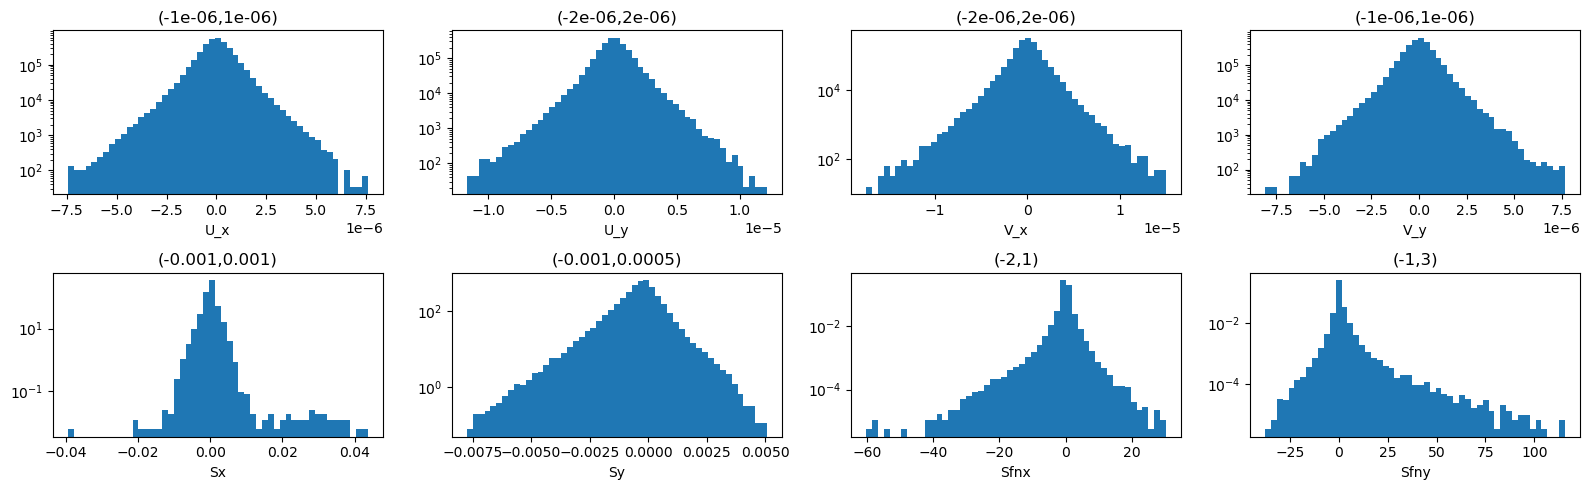

In [56]:
fig, ax = plt.subplots(2, 4, figsize=(16, 5)) 

for i, var in enumerate(vars_plot): 
    if i<4:
        ax[0,i].hist(dp.sample(100000)[var], bins=51, density=True)
        ax[0,i].set_yscale('log')
        ax[0,i].set_xlabel(var)
        ranges = np.percentile(dp.sample(100000)[var], (10, 90))
        ax[0,i].set_title('(%.1g' % ranges[0]+',%.1g)'%ranges[1])
    else:
        ax[1,i-4].hist(dp.sample(100000)[var], bins=51, density=True)
        ax[1,i-4].set_yscale('log')
        ax[1,i-4].set_xlabel(var)
        ranges = np.percentile(dp.sample(100000)[var], (10, 90))
        ax[1,i-4].set_title('(%.1g' % ranges[0]+',%.1g)'%ranges[1])

plt.tight_layout()

#plt.sample
plt.savefig('var_dist_'+L+'.pdf')

In [30]:
print("%.1e" % ranges[0])

-1.6e+00


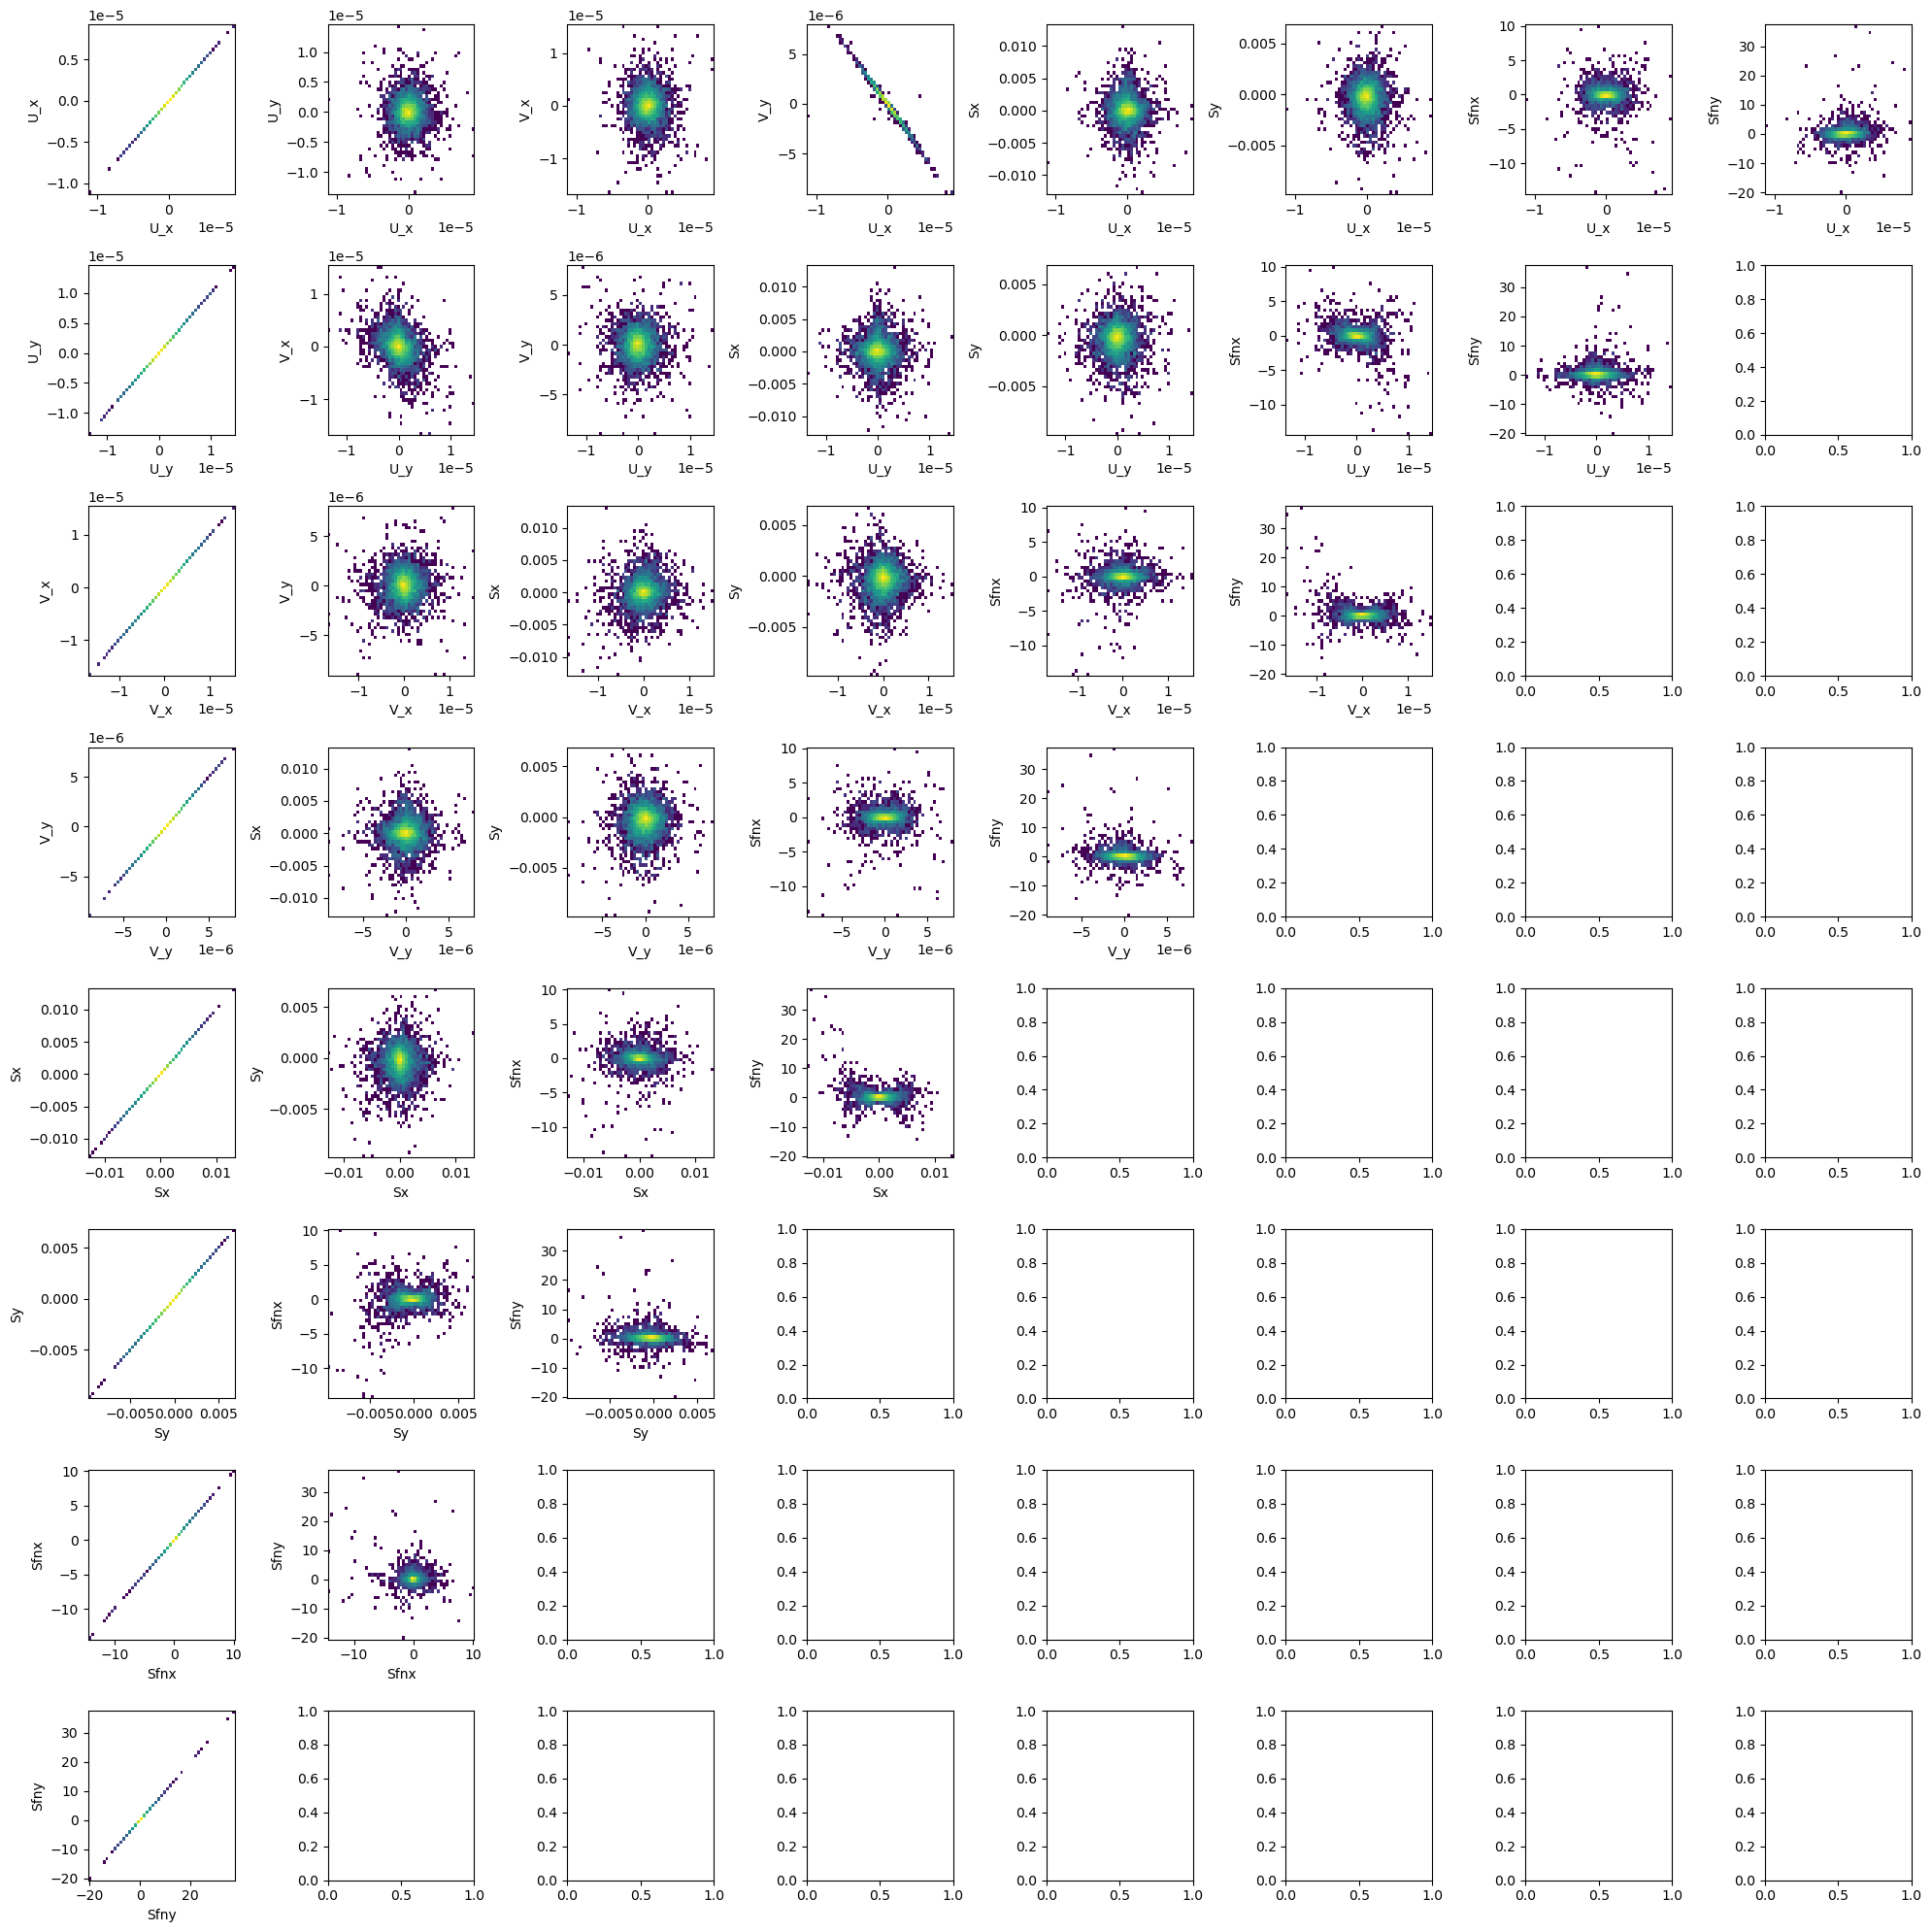

In [20]:
fig, ax = plt.subplots( len(vars_plot), len(vars_plot),figsize=(20, 20)) 

n= 5000

dp_samp = dp.sample(n)

for i, var1 in enumerate(vars_plot): 
    for j, var2 in enumerate(vars_plot[i:]):
        
        ax[i,j].hist2d(dp_samp[var1], dp_samp[var2], bins=(51,51), norm=LogNorm(), vmin=None, vmax=None);
        #ax[i,j].set_yscale('log')
        ax[i,j].set_xlabel(var1)
        ax[i,j].set_ylabel(var2)

plt.tight_layout()